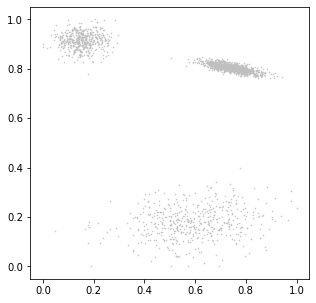

In [83]:
import numpy as np 
import numpy.matlib 
import matplotlib.pyplot as plt

# np.random.rand = uniform random generation, [0, 1]
# np.random.randn = normal random generation, N(0, 1)
r1 = 10*(np.random.rand(2,2) - 0.5)
r2 = 10*(np.random.rand(2,2) - 0.5)
r3 = 10*(np.random.rand(2,2) - 0.5)

t1 = 50*(np.random.rand(1,2) - 0.5)
t2 = 50*(np.random.rand(1,2) - 0.5)
t3 = 50*(np.random.rand(1,2) - 0.5)

X1 = np.random.randn(1000,2)
X1 = X1.dot(r1) + t1

X2 = np.random.randn(500,2)
X2 = X2.dot(r2) + t2

X3 = np.random.randn(500,2)
X3 = X3.dot(r3) + t3

# unlabel data
X = np.vstack([X1, X2, X3])
np.random.shuffle(X)

# normalization
Xmin = np.min(X, axis = 0)
X = (X - Xmin)

Xmax = np.max(X, axis = 0)
X = X / Xmax

plt.figure(figsize = (5,5))
plt.plot(X[:,0],X[:,1],".",markersize = 1, color = [0.75, 0.75, 0.75])

N,D = X.shape

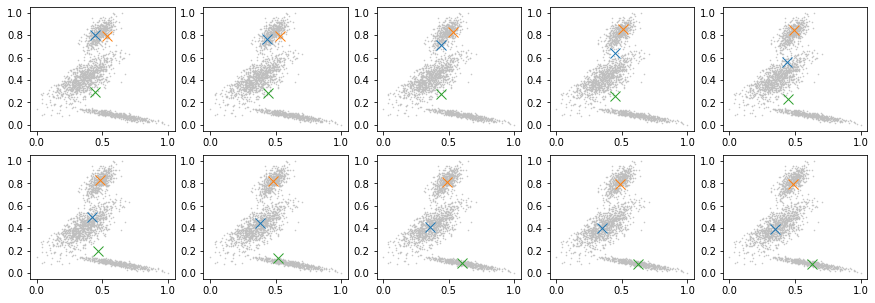

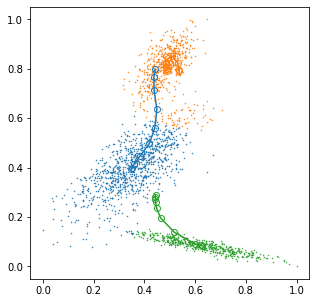

In [79]:
# parameter
K = 3
iterMax = 10

# initialize
(N, D) = X.shape
mu_traj= np.zeros((K,D,iterMax))

# mu를 랜덤으로 초기화, 각 열 = 각 cluster의 중심
mu = np.random.rand(K,D)

# n번째 sample부터, k번째 cluster의 중심까지의 거리**2
dist2 = np.zeros((N,K)) 

plt.figure(figsize = (15,5))
for iter in range(0,iterMax):
    for k in range(0,K):
        dist2[:,k] = np.sum((X - np.matlib.repmat(mu[k,:],N,1))**2, axis = 1)

    # 어느 cluster까지 제일 가까운지를 저장
    c = np.argmin(dist2, axis = 1)
    r = np.zeros((N,K), dtype = bool)
    r[np.arange(N),c] = 1

    # 각 cluster에 대해 mu를 업데이트
    for k in range(0,K):
#         mu[k,:] = np.mean(X[c == k,:], axis = 0)
        mu[k,:] = np.mean(X[r[:,k],:], axis = 0)
    
    # iteration별로 mean 저장
    mu_traj[:,:,iter] = mu
        
    plt.subplot(2,5,iter + 1)
    plt.plot(X[:,0],X[:,1],".",markersize = 1, color = [0.75, 0.75, 0.75])
    for k in range(0,K):
        plt.plot(mu[k,0],mu[k,1],"x",markersize = 10)


plt.figure(figsize = (5,5))
# plt.plot(X[:,0],X[:,1],".",markersize = 1, color = [0.75, 0.75, 0.75])
for k in range(0,K):
    plt.plot(X[c == k,0],X[c == k,1],".",markersize = 1)
plt.gca().set_prop_cycle(None)
for k in range(0,K):
    plt.plot(mu_traj[k,0,:],mu_traj[k,1,:],'o-',fillstyle = 'none')

(0.0, 1.554162143477235)

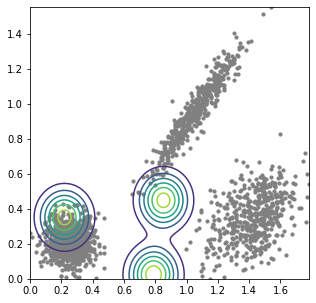

In [60]:
from scipy.stats import multivariate_normal

K = 3
iterMax = 10 # 최대 몇번 iteration을 반복할건지

# initial parameter
N,D = X.shape

pi = np.random.rand(K)
pi = pi / np.sum(pi)
mu = np.random.rand(K,D)
sigma = np.zeros((D,D,K))
for k in range(0,K):
    sigma[:,:,k] = 1e-2*np.identity(D)
    
# initialize
Num = np.zeros(K)

# draw contour
u = np.linspace(-5,5,1000)
v = np.linspace(-5,5,1000)
uu, vv = np.meshgrid(u, v)
mog_pdf = np.zeros(uu.shape)
for k in range(0,K):
    pdf = multivariate_normal.pdf(np.hstack((uu.reshape(-1,1),vv.reshape(-1,1))), mean = mu[k,:], cov = sigma[:,:,k])
    mog_pdf += pi[k] * pdf.reshape(1000,1000)

plt.figure(figsize = (5,5))
plt.scatter(X[:,0],X[:,1],s = 10,color = "gray")
plt.contour(uu,vv,mog_pdf)
plt.xlim([np.min(X[:,0]),np.max(X[:,0])])
plt.ylim([np.min(X[:,1]),np.max(X[:,1])])

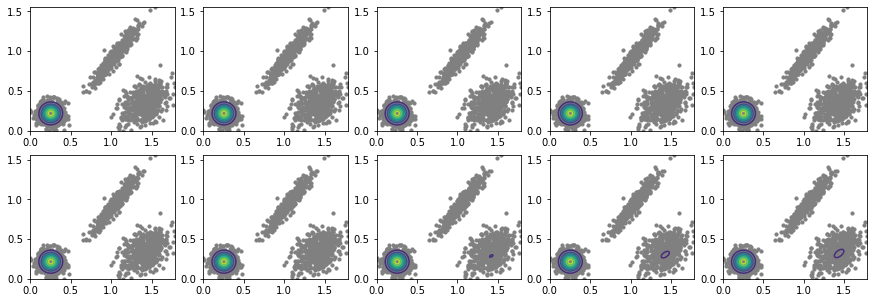

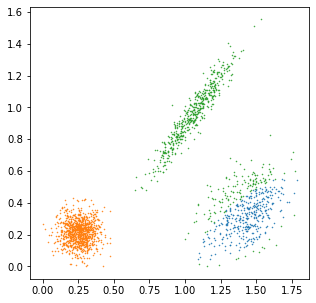

In [61]:

plt.figure(figsize = (15,5))
for iter in range(0, iterMax):

    # responsibility
    gamma = np.zeros((N,K))
    for k in range(0,K):
        gamma[:,k] = pi[k]*multivariate_normal.pdf(X,mean = mu[k,:], cov = sigma[:,:,k])
    gamma = gamma / np.matlib.repmat(np.sum(gamma, axis = 1).reshape(-1,1), 1, K)

    # iteration
    for k in range(0,K):
        Num[k] = np.sum(gamma[:,k])

        mu[k,:] = np.sum(np.matlib.repmat(gamma[:,k].reshape(-1,1), 1, D)*X, axis = 0) / Num[k]

        res = (X - np.matlib.repmat(mu[k,:].reshape(1,-1),N,1))
        gamma_res = np.matlib.repmat(gamma[:,k].reshape(N,1),1,D) * res
        for n in range(0,N):
            sigma[:,:,k] += res[n,:].reshape(-1,1).dot(gamma_res[n,:].reshape(-1,1).T)
        sigma[:,:,k] /= Num[k]
#         sigma[:,:,k] += 1e-6*np.identity(D)        

        pi[k] = Num[k] / N

    # draw contour
    mog_pdf = np.zeros(uu.shape)
    for k in range(0,K):
        pdf = multivariate_normal.pdf(np.hstack((uu.reshape(-1,1),vv.reshape(-1,1))), mean = mu[k,:], cov = sigma[:,:,k])
        mog_pdf += pi[k] * pdf.reshape(1000,1000)

    plt.subplot(2,5,iter + 1)
    plt.scatter(X[:,0],X[:,1],s = 10,color = "gray")
    plt.contour(uu,vv,mog_pdf)
    plt.xlim([np.min(X[:,0]),np.max(X[:,0])])
    plt.ylim([np.min(X[:,1]),np.max(X[:,1])])    
    

label = np.argmax(gamma, axis = 1)

plt.figure(figsize = (5,5))
for k in range(0,K):
    plt.plot(X[label == k,0],X[label == k,1],".",markersize = 1)